# Definición de Paseo Aleatorio, Regresión y Modelos de Ruido Blanco



<img src="Users\migue\OneDrive\Escritorio\CIMA.jpg">



Dataset: [S&P 500 (SPX) Historical Data - Nasdaq](https://www.nasdaq.com/market-activity/index/spx/historical?page=5&rows_per_page=10&timeline=y5)

In [2]:
!pip install fbm


[notice] A new release of pip is available: 23.3 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Importamos librerías básicas de Python
import numpy as np # vectores y matrices
from fbm import FBM # Movimiento Browniano fraccional (solo como ejemplo: https://pypi.org/project/fbm)
import pandas as pd # dataframes
import statsmodels.api as sm # lib. general de Statsmodels
import matplotlib.pyplot as plt # ploteo básico
from statsmodels.tsa.stattools import acf # func. de autocorr.
from statsmodels.graphics.tsaplots import plot_acf # func. de correlograma

# Evitemos algunos mensajes de warning por conveniencia (no recomendable para sus proyectos)
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Leemos los el .CSV ("comma-separated value") como Dataframe
data = pd.read_csv("Historical_SP500.csv")

Observemos los valores iniciales y finales.

In [8]:
# Valores iniciales
data.head()

,Date,Close/Last,Open,High,Low
0,07/11/2024,5584.54,5635.21,5642.45,5576.53
1,07/10/2024,5633.91,5591.26,5635.39,5586.44
2,07/09/2024,5576.98,5584.24,5590.75,5574.57
3,07/08/2024,5572.85,5572.75,5583.11,5562.51
4,07/05/2024,5567.19,5537.91,5570.33,5531.63


In [9]:
# Valores finales
data.tail()

,Date,Close/Last,Open,High,Low
1253,07/18/2019,2995.11,2978.87,2998.28,2973.09
1254,07/17/2019,2984.42,3005.10,3005.26,2984.25
1255,07/16/2019,3004.04,3012.13,3015.02,3001.15
1256,07/15/2019,3014.30,3017.80,3017.80,3008.77
1257,07/12/2019,3013.77,3003.36,3013.92,3001.87


Notamos que los datos están invertidos temporalmente. Entonces, ordenémoslo, de modo tal que primero tengamos las fechas más antiguas y, al final, las más recientes.

In [10]:
# Invirtiendo orden del dataframe
data = data[::-1].reset_index(drop=True)

In [11]:
# Imprimamos la primera fecha y la última
print(f">> Fecha más antigua: {data.Date.iloc[0]}")
print(f">> Fecha más reciente: {data.Date.iloc[-1]}")

>> Fecha más antigua: 07/12/2019
>> Fecha más reciente: 07/11/2024


Ahora, veamos el tipo de cada categoría en nuestro dataset y visualicemos la serie:

In [10]:
# Tipo de dato por columna 
data.dtypes

Date           object
Close/Last    float64
Open          float64
High          float64
Low           float64
dtype: object

Notamos que el tipo de dato `Date` es un objeto. Sería mejor definirlo como un `Datetime`. 

In [14]:
# Convirtiendo columna `Date` a formato pd.datetime
data.Date = pd.to_datetime(data.Date) 
data.dtypes

Date          datetime64[ns]
Close/Last           float64
Open                 float64
High                 float64
Low                  float64
dtype: object

Finalmente, ploteamos nuestra serie de tiempo.

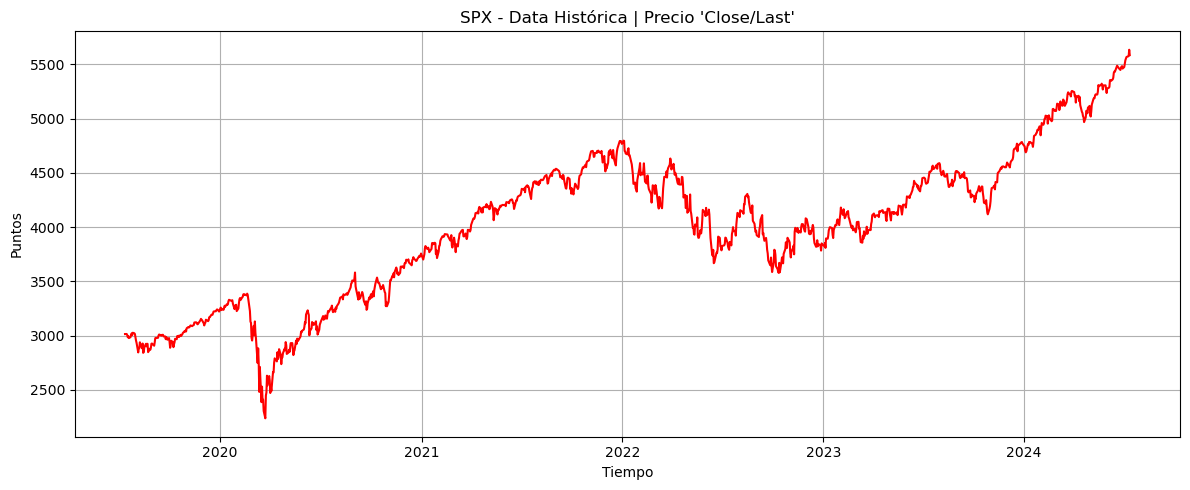

In [15]:
# Ploteamos la serie utilizando la columna 'Close/Last' 
plt.figure(figsize=(12,5)) # tamano del plot
plt.plot(data["Date"], data["Close/Last"], color="red")
plt.xlabel("Tiempo")
plt.ylabel("Puntos")
plt.title("SPX - Data Histórica | Precio 'Close/Last'")
plt.grid(True)
plt.tight_layout()
plt.show()

Para fines de la presente clase, definiremos un dataframe tomando en cuenta únicamente la columna `Close/Last`, que definiremos por conveniencia como `Price` en una variable llamada `timeSeries`. La columna `Date` también estará incluida. 

In [16]:
# Definiendo nueva variable para trabajar durante el presente notebook
timeSeries = data[["Date", "Close/Last"]].rename(columns={'Close/Last': 'Price'})
timeSeries.head()

,Date,Price
0,2019-07-12,3013.77
1,2019-07-15,3014.30
2,2019-07-16,3004.04
3,2019-07-17,2984.42
4,2019-07-18,2995.11


***

## 1. Correlograma - Primeros ejemplos

Recordar que nuestra función de autocorrelación, para una serie $\{X\}_t$, se define como:

$$
ACF(k):=r_{\rho, k}(X) \space\space\space\space\space \forall k=1:n
$$

donde:

$$
r_{\rho, k}(X) = \frac{c_k(X)}{c_0(X)} \space\space\space\space,\space \text{tal que: } c_k(X)=\frac{1}{n}\sum_{t=1}^{n-k}(x_t - \bar{X})(x_{t+k}-\bar{X})
$$

siendo $\bar{X} = \sum_{} $ la media muestral y $c_k$ la autocovarianza muestral.

Entonces, empecemos creando una función en Python que siga esta fórmula:

In [17]:
# Función para calcular el ACF usando nuestra fórmula de la Sesión 2
def acf_manual(x, nlags):
    
    # Calcular X barra, es decir, la media de la serie temporal
    x_mean = np.mean(x)
    
    # Calcular c0 (varianza), ya que es constante (k=0)
    c0 = np.sum((x - x_mean) ** 2) / len(x)
    
    # Inicializar la lista de autocorrelaciones (ACF = 1 en K = 0)
    acf_values = [1.0] 
    
    # Calcular autocorrelaciones para cada retardo k
    for k in range(1, nlags + 1): # range(1, 10) = 1, 2, ..., 9
        # Calcular ck
        ck = np.sum((x[:len(x)-k] - x_mean) * (x[k:] - x_mean)) / len(x)
        
        # Calcular el coeficiente de autocorrelación rk
        r_k = ck / c0
        
        # Agregar r_k a la lista de valores ACF
        acf_values.append(r_k)
    
    return np.array(acf_values)

Ahora, obtengamos las autocorrelaciones con nuestra data para $k=50$:

In [18]:
# Calcular el ACF usando nuestra función
acf_vals_manual = acf_manual(timeSeries.Price.values, nlags = 50)
acf_vals_manual

array([1.        , 0.99457936, 0.9895092 , 0.98430528, 0.97918394,
       0.97424199, 0.96914709, 0.96460659, 0.95959265, 0.95512486,
       0.9498386 , 0.94488396, 0.93981695, 0.93479164, 0.92991616,
       0.92466809, 0.91971095, 0.91447078, 0.90963812, 0.90455857,
       0.89958676, 0.89467647, 0.88955133, 0.88499945, 0.8803065 ,
       0.87568458, 0.87143586, 0.86743901, 0.86313749, 0.85899394,
       0.85474097, 0.85036662, 0.84614096, 0.84206821, 0.83794532,
       0.8337557 , 0.82950836, 0.82501757, 0.82069929, 0.81637997,
       0.81237381, 0.80855701, 0.8050132 , 0.80140868, 0.79790155,
       0.79439993, 0.7907634 , 0.78741742, 0.7840466 , 0.78092271,
       0.77776529])

Finalmente, ploteemos los resultados:

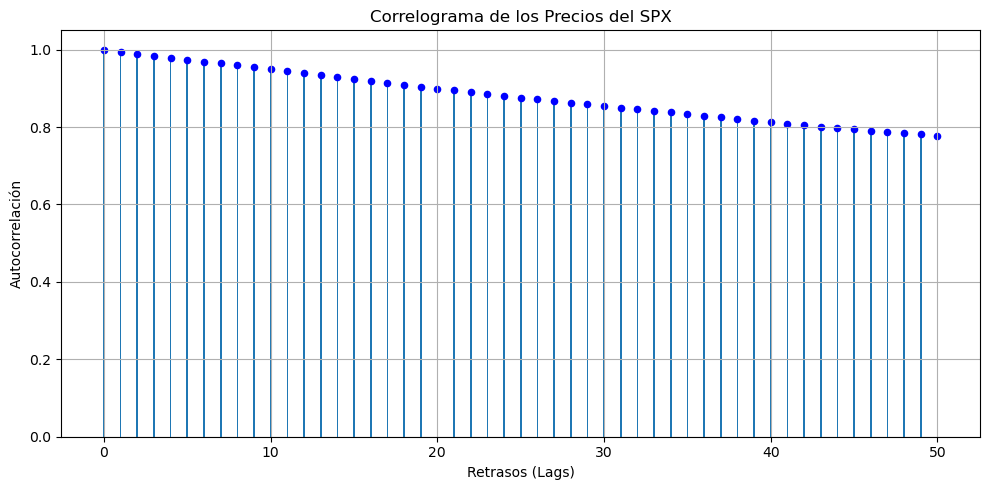

In [19]:
# Graficar el correlograma
plt.figure(figsize=(10, 5))

# Graficar las barras de autocorrelación
plt.bar(range(50 + 1), acf_vals_manual, width=0.1)
plt.scatter(range(50 + 1), acf_vals_manual, s=20, color="blue")

# Etiquetas y título del gráfico
plt.title('Correlograma de los Precios del SPX')
plt.xlabel('Retrasos (Lags)')
plt.ylabel('Autocorrelación')

# Mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

Usualmente, no necesitamos seguir esta fórmula en Python, ya que podemos utilizar la librería `statsmodel`; en particular, la funcionalidad `acf` para obtener las autocorrelaciones, o `plot_acf` para obtener directamente el correlograma.

Primero, obtengamos las correlaciones con `statsmodel`:

In [20]:
# ACF de statsmodel, con lag 50
acf_sm = acf(timeSeries['Price'], nlags=50)
acf_sm

array([1.        , 0.99457936, 0.9895092 , 0.98430528, 0.97918394,
       0.97424199, 0.96914709, 0.96460659, 0.95959265, 0.95512486,
       0.9498386 , 0.94488396, 0.93981695, 0.93479164, 0.92991616,
       0.92466809, 0.91971095, 0.91447078, 0.90963812, 0.90455857,
       0.89958676, 0.89467647, 0.88955133, 0.88499945, 0.8803065 ,
       0.87568458, 0.87143586, 0.86743901, 0.86313749, 0.85899394,
       0.85474097, 0.85036662, 0.84614096, 0.84206821, 0.83794532,
       0.8337557 , 0.82950836, 0.82501757, 0.82069929, 0.81637997,
       0.81237381, 0.80855701, 0.8050132 , 0.80140868, 0.79790155,
       0.79439993, 0.7907634 , 0.78741742, 0.7840466 , 0.78092271,
       0.77776529])

Comprobemos que son exactamente las mismas que con nuestra función (hasta 10 decimales):

In [21]:
print(f">> Autocorrelaciones iguales? : \
{np.all(np.round(acf_vals_manual, 10) == np.round(acf_sm, 10))}")

>> Autocorrelaciones iguales? : True


Ahora, obtengamos el plot correspondiente al correlograma con `plot_acf`. Note que no debemos calcular los valores de autocorrelación, ya que `statsmodel` lo hará por nosotros.

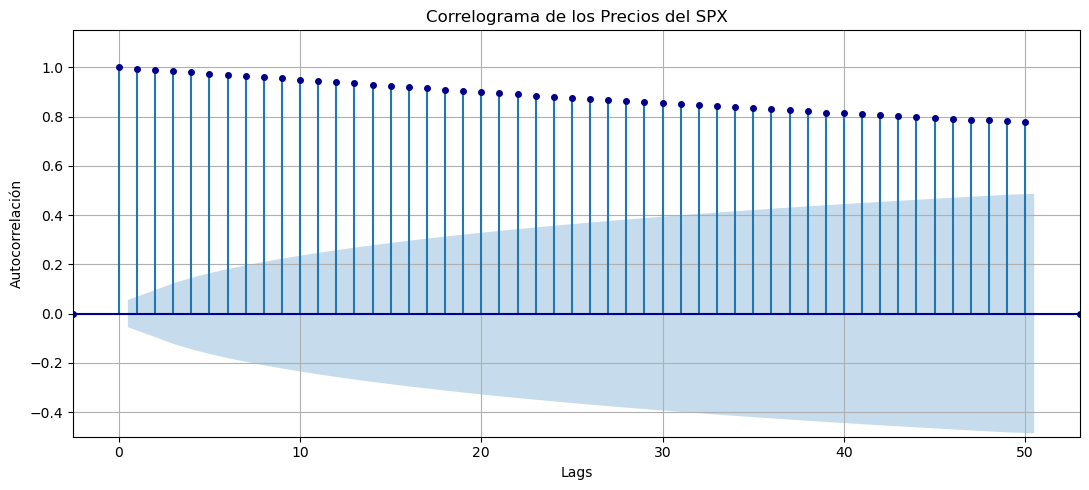

In [22]:
# Tamaño del plot
fig, ax = plt.subplots(figsize=(11, 5))

# Crear y ajustar el correlograma con 50 rezagos (lag) | Func. de statsmodel
plot_acf(timeSeries['Price'], 
         lags=50, ax=ax, 
         color='darkblue', 
         marker='o', markersize=4)

# Ajustes adicionales para la presentación
ax.set_title('Correlograma de los Precios del SPX')
ax.set_xlabel('Lags')
ax.set_ylabel('Autocorrelación')
ax.grid(True)
ax.set_ylim(-0.5, 1.15)

# Mostrar el plot
plt.tight_layout()
plt.show()

### IMPORTANTE: ¿qué es la zona sombreada?

La zona sombreada en el correlograma representa **los intervalos de confianza para los coeficientes de autocorrelación en diferentes retrasos**. Estos intervalos ayudan a determinar si las autocorrelaciones observadas son estadísticamente significativas, o no. A nivel general, todo valor de autocorrelación (todo punto de cada barra) fuera de esta área significa que dicha autocorrelación es estadísticamente relevante y, por tanto, NO puede ser omitida. 

Si es que los ACF son significativos, podemos darnos una idea  que la serie de tiempo a estudio no es estacionario.

A nivel general, el diseño de hipótesis utilizado para calcular el área sombreada utiliza el Error Estándar ($\text{SE}$) ajustado por observación de retraso $k$, definido como los _grados de libertad_. La fórmula que define el $\text{SE}$ es conocida como $\text{Fórmula de Bartlett}$, que da pie al $\text{Intervalo de Confianza de Bartlett}$.


**Prueba de hipótesis | Fórmula de Bartlett**

- Hipótesis nula (H0): 

> La serie temporal es un proceso de ruido blanco; es decir, no existe autocorrelación en ningún $k$.

- Hipótesis alternativa (H1): 

> La serie temporal tiene autocorrelación significativa en algún retraso $k$.

- Estadístico de prueba: 

> Este será el coeficiente de autocorrelación en cada retraso, obtenido de la función de autocorrelación; es decir, $r_{\rho, k^*}$ para un $k^*$ concreto.

- Regla de decisión: 

> Rechazar H0 _solo si_ $r_{\rho, k^*}$ se encuentra fuera del intervalo de confianza $\pm \text{CI}_{\alpha} \times \text{SE}(r_{k^*})$, donde $\alpha$ es el nivel de confianza deseado. Usualmente, $\alpha = 95\%$, tal que $CI_{95\%} \approx 1.96$. 

La fórmula de Bartlett definirá $\text{SE}$, tal que:

$$ \text{SE}(r_k) = \sqrt{\frac{1}{N} \left(1 + 2 \sum_{i=1}^{k-1} r_i^2 \right)} $$

A la fórmula anterior también se le conoce  como un proceso $\text{MA}(k-1)$; es decir, un proceso de media móvil con retrazo $k-1$ (más de esto en la sesión 4). Por tanto, en esta PH, el error estándar se definirá bajo la asunción de que el modelo correcto para nuestro conjunto de datos fuera un $\text{MA}(k-1)$.

Note que la raíz del proceso se debe a que, por definición, $\text{SE} = \sqrt{\frac{\sigma^2}{N}}$, donde $N$ es el total de observaciones. Por ende, dado que se asume un _ruido blanco gaussiano_ para H0, entonces $\sigma^2 = 1$.

**Veamos un ejemplo con los datos** (hasta $k = 3$).

En nuestro dataset, tenemos: 

In [27]:
print(f">> N = {timeSeries.shape[0]}")


>> N = 1259


Evaluemos hasta $k=3$ a partir de los datos obtenidos para la función $\text{ACF}(X)$ de `statsmodel`. Redondeemos cada valor a solo $4$ decimales por conveniencia. 

In [23]:
# Redondeamos cada valor a 4 decimales hasta k = 3
acf_ejemplo_k5 = np.round(acf_sm[:4], 4) # note que usamos '4' ya que el primer valor es k = 0
print(f">> ACF(X, k=5): {acf_ejemplo_k5}")

>> ACF(X, k=5): [1.     0.9946 0.9895 0.9843]


Entonces, omitiendo $k=0$, tenemos:

$$ \text{SE}(r_k) = \sqrt{\frac{1}{N} \left(1 + 2 \sum_{i=1}^{k-1} r_i^2 \right)} $$

1. **Retraso 1**:
   $
   \text{SE}(r_1) = \sqrt{\frac{1}{1259}\left(1+2\times0\right)} \approx 0.0282
   $
   Intervalo de Confianza:
   $
   0.9947 \pm 1.96 \times 0.0282 = [0.9394, 1.0499]
   $

2. **Retraso 2**:
   $
   \text{SE}(r_2) = \sqrt{\frac{1}{1259} \left(1 + 2 \times 0.9947^2 \right)} \approx 0.0486
   $
   Intervalo de Confianza:
   $
   0.9897 \pm 1.96 \times 0.0486 = [0.8944, 1.0850]
   $

3. **Retraso 3**:
   $
   \text{SE}(r_3) = \sqrt{\frac{1}{1259} \left(1 + 2 \times (0.9947^2 + 0.9897^2) \right)} \approx 0.06263
   $
   Intervalo de Confianza:
   $
   0.9846 \pm 1.96 \times 0.06263 = [0.8618, 1.1073]
   $


Y continuamos sucesivamente para todos los $k$.

Finalmente, comprobemos estos valores dirctamente con la función `acf` de `statsmodel`:

In [29]:
# Bartlett IC
print(f"Barlett IC (k = 0:3): \n{acf(timeSeries.Price, nlags=3, alpha=0.05)[1]}")

Barlett IC (k = 0:3): 
[[1.         1.        ]
 [0.93942723 1.04990254]
 [0.89440969 1.08507857]
 [0.86182122 1.10731275]]


Es importante recordar que `statsmodel` calculará por defecto el intervalo de Bartlett con un nivel de confianza del $95\%$.

### IMPORTANTE: ¿cómo se vería un correlograma de una secuencia de variables aleatorias normales?

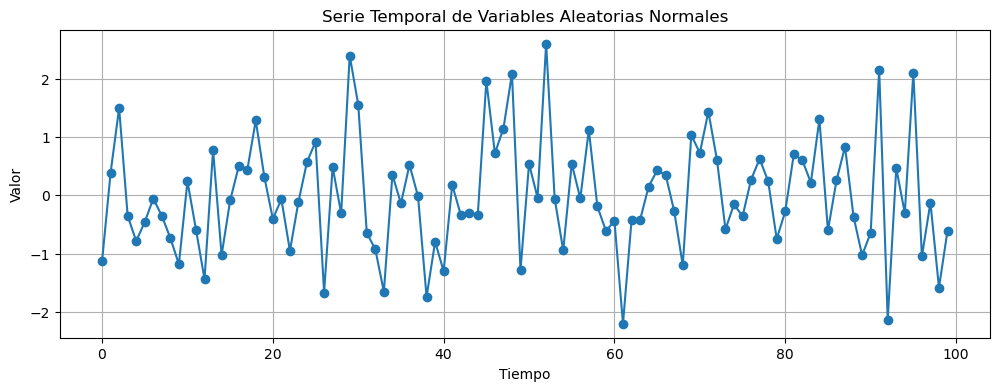

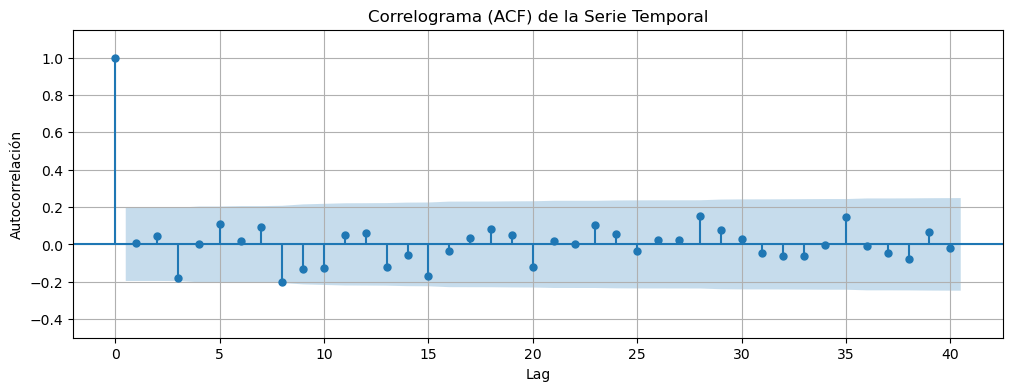

In [24]:
# Generar una serie temporal de variables aleatorias normales
np.random.seed(111)  # Fijar la semilla para reproducibilidad
n = 100  # Número de observaciones
random_series = np.random.normal(size=n)

# Graficar la serie temporal
plt.figure(figsize=(12, 4))
plt.plot(random_series, marker='o', linestyle='-')
plt.title('Serie Temporal de Variables Aleatorias Normales')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

# Generar y graficar el correlograma (ACF plot)
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(random_series, lags=40, ax=ax)
ax.set_title('Correlograma (ACF) de la Serie Temporal')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelación')
ax.set_ylim(-0.5, 1.15)
plt.grid(True)
plt.show()

***

## 2. Procesos de memoria larga y corta

En la clase anterior, brindamos dos definiciones de procesos de memoria larga y corta: la primera utilizando la $\text{ACF}$, y la segunda utilizando la definición de procesos estocásticos en espacios continuos. A continuación, trabajaremos ambas definiciones.

### 2.1. Definición estándar

A nivel general, dijimos que una serie temporal con una $\text{ACF}$ que decae _exponencialmente_, o a un ritmo mucho mayor, se conoce como de **memoria corta**. En contraste, una serie temporal tiene **memoria larga** si esa misma $\text{ACF}$ decae _más lentamente_ que un decaimiento exponencial. 

De hecho, utilizando el correlograma nuestra serie de tiempo del `SPX`, podemos decir que esta sigue un **proceso de memoria larga**. 

In [ ]:
# codigo de correlograma en celdas anteriores

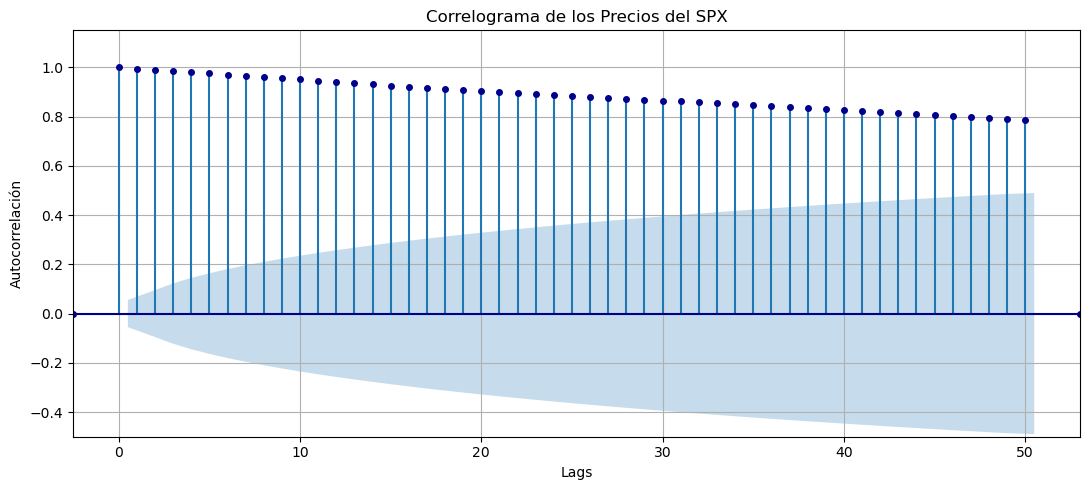

En contraste, un clásico ejemplo de **memoria corta** (extrema o, rigurosamente, _sin memoria_) puede encontrarse en el ruido blanco; es decir, en el segundo tipo de correlograma que obtuvimos sobre **una secuencia de variables aleatorias normales**:

In [ ]:
# codigo de correlograma en celdas anteriores

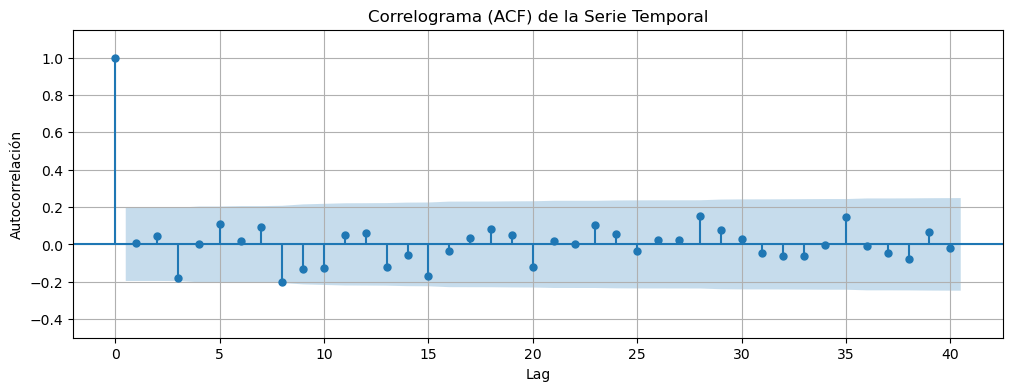

Ahora bien, un ejemplo intermedio y clásico de **memoria corta** es un _proceso autoregresivo de primer orden_, o **AR(1)** (más de esto en la sesión 4), definido como:

$$
x_t =  \beta x_{t-1} + \epsilon_t
$$

donde $\epsilon_t \sim \mathbb{N}(0, \sigma^2) \space \land \space \beta \in \space ]-1, 1[$. 

Aquí, $\beta$ es conocido como el _parámetro de persistencia_, y dicha condición es conocida como _condición de varianza finita_.

### IMPORTANTE: ¿cómo sabemos que dicho proceso AR(1) es de memoria corta?

> Tenemos que ver la forma de $\rho_k$ (es decir, la forma que toma su función de autocorrelación). Note que estamos usando la definición teórica de autocorrelación para un $k$ dado (en el caso de AR(1), $k=1$), ya que es más conveniente para la demostración.

Así, para evaluar $\rho_{k}$, primero debemos conocer la media y varianza de $x_t$.

1. **Media y Varianza del Proceso AR(1)**

   La media es $\mathbb{E}[x_t] = 0$ dado que $\epsilon_t \sim \mathbb{N}(0, \sigma^2)$. Esto se debe a que el proceso es necesariamente estacionario (de 2do orden, es decir, con media y varianza constante).

   Para demostrarlo, tomemos la esperanza del proceso AR(1):

   $\mathbb{E}[x_t] = \mathbb{E}[\beta x_{t-1} + \epsilon_t]$

   Aplicando la linealidad de la esperanza:

   $\mathbb{E}[x_t] = \beta \mathbb{E}[x_{t-1}] + \mathbb{E}[\epsilon_t]$

   Dado que $\mathbb{E}[\epsilon_t] = 0$:

   $\mathbb{E}[x_t] = \beta \mathbb{E}[x_{t-1}]$

   Para que el proceso sea estacionario, $\mathbb{E}[x_t]$ debe ser constante para todo $t$. Por lo tanto:

   $\mu = \beta \mu$

   Donde $\mu$ es la media constante de $x_t$. Para que esta igualdad se mantenga, **$\mu$ debe ser $0$**, ya que $\beta \neq 1$:

   $\mu = 0$

   Por lo tanto, la media del proceso $x_t$ es $0$ si $\epsilon_t$ tiene media $0$.

   Asimismo, la varianza del proceso, $\text{Var}(x_t)$, se puede encontrar considerando que en el largo plazo la varianza de $x_t$ se estabiliza (ya que, como sabemos, todo proceso estacionario tiene _varianza finita_). 
   
   La varianza se definirá como:

   $\text{Var}(x_t) = \beta^2 \text{Var}(x_{t-1}) + \text{Var}(\epsilon_t)$

   Dado que $\text{Var}(\epsilon_t) = \sigma^2$, tenemos:

   $\sigma_x^2 = \beta^2 \sigma_x^2 + \sigma^2$

   Resolviendo para $\sigma_x^2$:

   $\sigma_x^2 (1 - \beta^2) = \sigma^2$

   $\sigma_x^2 = \frac{\sigma^2}{1 - \beta^2}$



2. **Función de Autocorrelación $\rho_k$ para AR(1)**

   Nosotros sabemos que la función de autocorrelación (teórica) de orden $k$ se define como:

   $\rho_k = \frac{\text{Cov}(x_t, x_{t-k})}{\sqrt{\text{Var}(x_t)\text{Var}(x_{t-k})}} = \frac{\text{Cov}(x_t, x_{t-k})}{\text{Var}(x_t)}$

   Para un proceso AR(1), consideramos $k = 1$:

   $\text{Cov}(x_t, x_{t-1}) = \mathbb{E}[x_t x_{t-1}] - \mathbb{E}[x_t]\mathbb{E}[x_{t-1}]$

   Dado que $\mathbb{E}[x_t] = 0$:

   $\text{Cov}(x_t, x_{t-1}) = \mathbb{E}[x_t x_{t-1}]$

   Sustituyendo $x_t = \beta x_{t-1} + \epsilon_t$:

   $\text{Cov}(x_t, x_{t-1}) = \mathbb{E}[(\beta x_{t-1} + \epsilon_t) x_{t-1}]$

   $\text{Cov}(x_t, x_{t-1}) = \beta \mathbb{E}[x_{t-1}^2] + \mathbb{E}[\epsilon_t x_{t-1}]$

   Dado que $\epsilon_t \perp x_{t-1}$ y $\mathbb{E}[\epsilon_t]=0 $, entonces:

   $\text{Cov}(x_t, x_{t-1}) = \beta \mathbb{E}[x_{t-1}^2]$

   Sabemos que $\mathbb{E}[x_{t-1}^2] = \text{Var}(x_{t-1}) = \sigma_x^2$ ya que $\mathbb{E}[x_{t-1}]^2=0$. Por ende:

   $\text{Cov}(x_t, x_{t-1}) = \beta \sigma_x^2$

   Entonces, la autocorrelación de primer orden es:

   $\rho_1 = \frac{\text{Cov}(x_t, x_{t-1})}{\text{Var}(x_t)} = \frac{\beta \sigma_x^2}{\sigma_x^2} = \beta$

   El valor se repetirá $\forall k > 1$, de modo que la función de autocorrelación para $\text{AR}(k)$ será:

   $$\rho_k = \beta^k$$
   
   donde $\beta \in \space ]-1, 1[$.

En la primera clase, vimos que un _modelo de crecimiento exponencial_ estaba definido como:

$$
x_{t} = ax_{t-1} 
$$

cuya solución general, para cualquier punto $n$ de la serie, estaba definida como:

$$
x_n = a^nx_o
$$

Definiendo $x_0 = 1$ (que es el caso para $k=0$ en la función de autocorrelación), obtendremos precisamente $\rho_k$ para $\text{AR}(k)$, donde $a = \beta$, $n=k$ y $\rho_k = x_n$. 

Asimismo, dado que $-1<\beta<1 \land k>0$, este será un modelo en su mayoría de _decrecimiento  exponencial_. Esto se debe a que el proceso AR(1) tiene una estructura recursiva, y la autocorrelación decaerá exponencialmente con el lag. 

Veamos un ejemplo concreto, recreando nuestro propio proceso $\text{AR}(1)$:

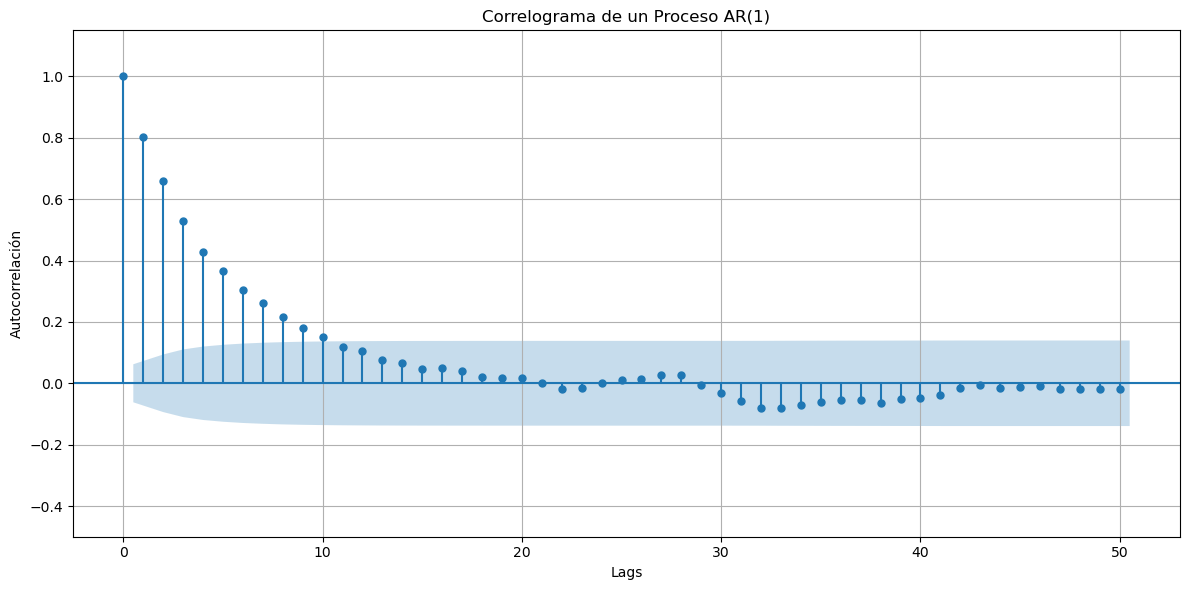

In [25]:
# Definimos un seed para reproductibilidad
np.random.seed(111)
n = 1000  # 1000 datos
beta = 0.8  # Parámetro de persistencia
# Primer valor del proceso AR
ar1 = np.zeros(n)
# Definimos un vector de valores para epsilon
epsilon = np.random.normal(size=n)

# Iteramos por cada valor de 'n'
for t in range(1, n):
    # Note que 't-1' es el equivalente a k=1 (lag de solo 1 valor)
    ar1[t] = beta * ar1[t-1] + epsilon[t]

# Crear una figura y un eje para el gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# Graficamos el correlograma del proceso AR(1)
plot_acf(ar1, lags=50, ax=ax)
ax.set_title('Correlograma de un Proceso AR(1)')
ax.set_xlabel('Lags')
ax.set_ylabel('Autocorrelación')
ax.set_ylim(-0.5, 1.15)
ax.grid(True)

# Mostrar la figura
plt.tight_layout()
plt.show()

> En otras palabras (a nivel teórico), cada vez que usemos la definición estándar, _y conozcamos la forma del proceso_, debemos ver la forma que tiene su función de autocorrelación $\rho_k$.

Sin embargo, ¿qué pasaría si no conocemos la forma del proceso? Una alternativa es simplemente plotear su correlograma y visualizar si este decae exponencialmente, pero eso es un método poco objetivo. ¿Qué otra opción tenemos?

### 2.2. Definición "rigurosa"

En la clase anterior, dijimos también que un proceso de memoria larga o corta puede definirse utilizando el **índice de Hurst** ($H$). 

Así, sea $\{B_{t_k}\}, \forall t_k \in [0, T]$ un Proceso Gaussiano, es decir, un proceso estocástico tal que toda combinación lineal de $(B_{t_1}, B_{t_2}, ..., B_{t_k})$ sigue una distribución normal. Entonces, dado que $B_{t_0} = 0$, $\mathbb{E}[B_t] = 0$, su covarianza está definida por:

$$
\mathbb{E}[B_{t_k} B_{t_s}]_H = \frac{1}{2} \left( |t_k|^{2H} + |t_s|^{2H} - |t_k - t_s|^{2H} \right), \quad \forall k \neq s
$$

Donde $H \in [0, 1]$ es el índice de Hurst, tal que:

- **$H > 0.5$**: Indica que los incrementos del proceso están positivamente correlacionados (proceso de memoria larga), también llamado "dependencia de largo alcance". Esto significa que un incremento positivo en el proceso tiende a ser seguido por otro incremento positivo, y de manera similar para decrecimientos.

- **$H < 0.5$**: Indica que los incrementos del proceso están negativamente correlacionados (proceso de memoria corta), también llamado "dependencia de corto alcance" o anti-persistencia. Esto significa que un incremento positivo en el proceso tiende a ser seguido por un decrecimiento, y viceversa.

- **$H = 0.5$**: Indica un proceso de paseo aleatorio estándar, o **movimiento browniano estándar**.

#### Interpretación del Índice de Hurst

El índice de Hurst, $H$, mide la dependencia temporal de los incrementos en una serie temporal:

- **Memoria Larga ($H > 0.5$)**: Indica persistencia en la serie temporal. Esto significa que el comportamiento futuro de la serie temporal tiene una dependencia positiva de su comportamiento pasado. **Por ejemplo, si una serie temporal ha estado aumentando, es probable que continúe aumentando**.

- **Memoria Corta ($H < 0.5$)**: Indica anti-persistencia. Esto significa que el comportamiento futuro de la serie temporal tiende a ser opuesto a su comportamiento pasado. **Por ejemplo, si una serie temporal ha estado aumentando, es probable que comience a disminuir**.

- **Sin Memoria ($H = 0.5$)**: Representa un paseo aleatorio estándar, llamado **movimiento browniano estándar**. 


**Datito**: cuando $H=0$ se le conoce como "pink noise" o "ruido rosa". Se le llama así ya que la correlacion del siguiente valor aleatorio con respecto del actual será exactamente inversamente proporcional.

Directamente, a travez de Python:

* Cuando $H=0.10$ (memoria corta):

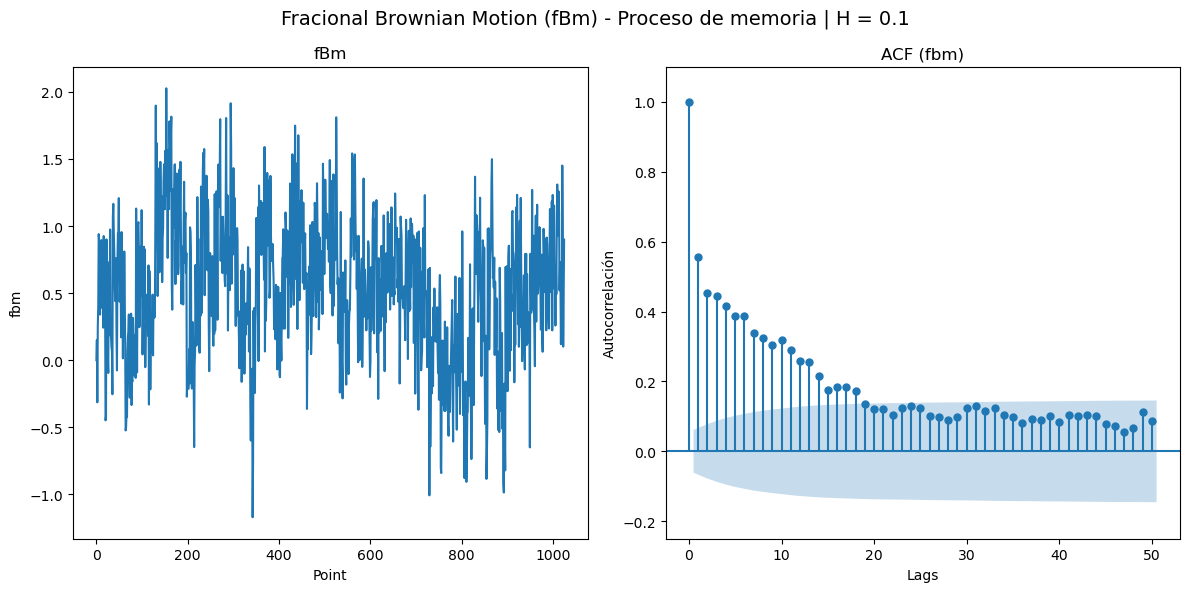

In [26]:
# Definimos el indice Hurst
H = 0.1

# Definimos un seed para reproductibilidad
np.random.seed(111)

# utilizamos nuestra function de mov. browniano fraccional
fbm_sm = FBM(n=1024, hurst=H, length=1)
fbm_sm_sample = fbm_sm.fbm()

# Creamos la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(
    f"Fracional Brownian Motion (fBm) - Proceso de memoria | H = {H}", 
    fontsize=14
)

# Primer subplot (proceso)
ax1.plot(fbm_sm_sample)
ax1.set_title(f'fBm')
ax1.set_xlabel('Point')
ax1.set_ylabel('fbm')

# Segundo subplot (ACF)
plot_acf(fbm_sm_sample, lags=50, ax=ax2)
ax2.set_title(f'ACF (fbm)')
ax2.set_xlabel('Lags')
ax2.set_ylabel('Autocorrelación')
ax2.set_ylim(-0.25, 1.10)

# Ploteamos
plt.tight_layout()
plt.show()

* Cuando $H=0.5$ (sin memoria):

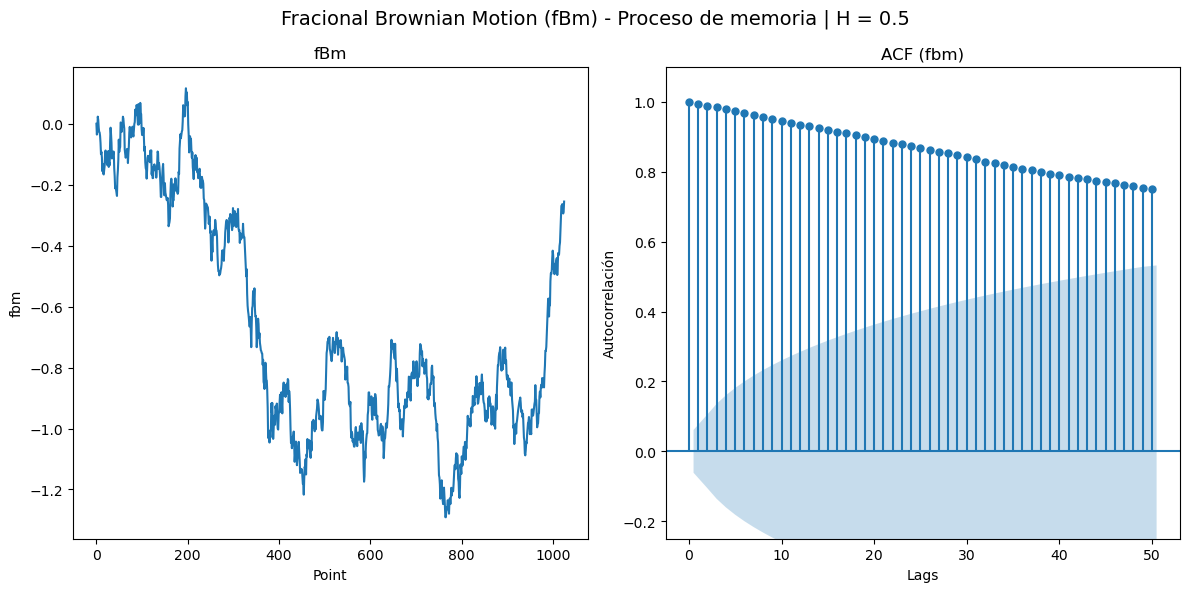

In [36]:
# Definimos el indice Hurst
H = 0.5

# Definimos un seed para reproductibilidad
np.random.seed(111)

# utilizamos nuestra function de mov. browniano fraccional
fbm_sm = FBM(n=1024, hurst=H, length=1)
fbm_sm_sample = fbm_sm.fbm()

# Creamos la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(
    f"Fracional Brownian Motion (fBm) - Proceso de memoria | H = {H}", 
    fontsize=14
)

# Primer subplot (proceso)
ax1.plot(fbm_sm_sample)
ax1.set_title(f'fBm')
ax1.set_xlabel('Point')
ax1.set_ylabel('fbm')

# Segundo subplot (ACF)
plot_acf(fbm_sm_sample, lags=50, ax=ax2)
ax2.set_title(f'ACF (fbm)')
ax2.set_xlabel('Lags')
ax2.set_ylabel('Autocorrelación')
ax2.set_ylim(-0.25, 1.10)

# Ploteamos
plt.tight_layout()
plt.show()

* Cuando $H=0.90$ (memoria larga):

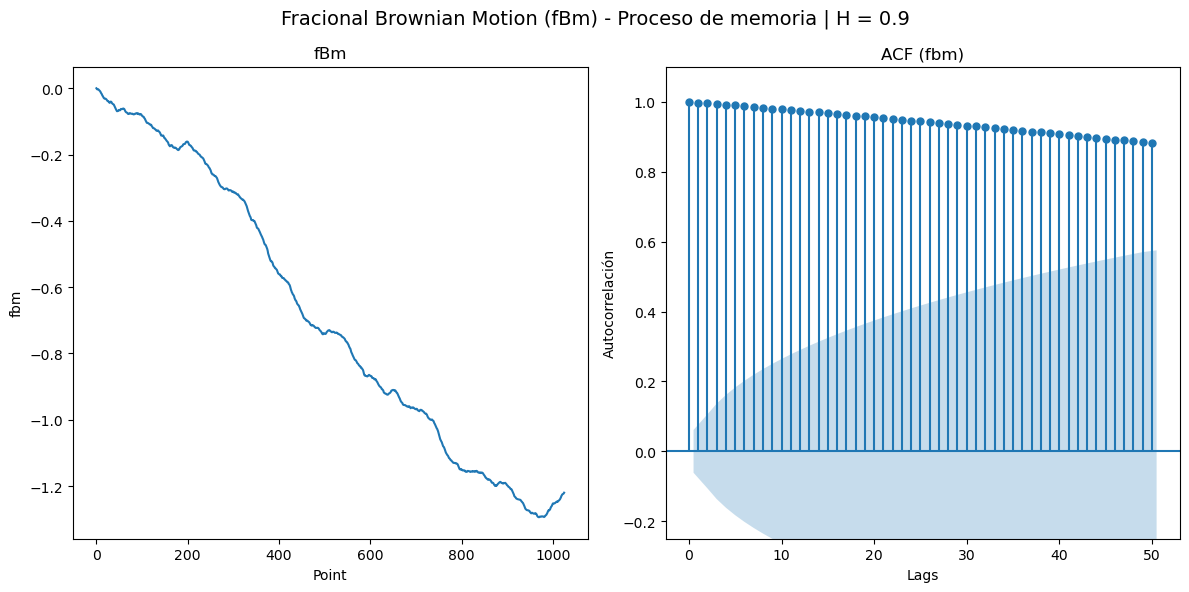

In [37]:
# Definimos el indice Hurst
H = 0.90

# Definimos un seed para reproductibilidad
np.random.seed(111)

# utilizamos nuestra function de mov. browniano fraccional
fbm_sm = FBM(n=1024, hurst=H, length=1)
fbm_sm_sample = fbm_sm.fbm()

# Creamos la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(
    f"Fracional Brownian Motion (fBm) - Proceso de memoria | H = {H}", 
    fontsize=14
)

# Primer subplot (proceso)
ax1.plot(fbm_sm_sample)
ax1.set_title(f'fBm')
ax1.set_xlabel('Point')
ax1.set_ylabel('fbm')

# Segundo subplot (ACF)
plot_acf(fbm_sm_sample, lags=50, ax=ax2)
ax2.set_title(f'ACF (fbm)')
ax2.set_xlabel('Lags')
ax2.set_ylabel('Autocorrelación')
ax2.set_ylim(-0.25, 1.10)

# Ploteamos
plt.tight_layout()
plt.show()

***

## 3. Paseo aleatorio y ruido blanco

### 3.1. Operadores matemáticos discretos 

#### 3.1.1 Operador de Desplazamiento Hacia Atrás (_Backward Shift Operator_, BSO)
El operador de desplazamiento hacia atrás, también conocido como operador lag o $B$, toma un elemento de una serie temporal y devuelve el mismo elemento $n$ unidades de tiempo hacia atrás.

$$
B^n x_t = x_{t-n}
$$

Este operador se utiliza comúnmente en el análisis de series temporales para crear funciones polinomiales que transforman una serie temporal en otra. Además, tiene un inverso, conocido como el operador de desplazamiento hacia adelante, denotado como $B^{-1}$, que desplaza un elemento hacia adelante en el tiempo.

En Python, el BSO puede hallarse con el operador `shift`. Veamos un ejemplo utilizando nuestra serie del `SPX` para $B(2)$:

In [27]:
# Creemos un dataframe nuevo con una columna que represente B(n2)
_bso2df_ = timeSeries[["Price"]].shift(2).rename(columns={"Price": "BSO(2)"})
# Creamos un dataframe nuevo concadenando el original 
bso2df = pd.concat([timeSeries, _bso2df_], axis=1)
bso2df.head()

,Date,Price,BSO(2)
0,2019-07-12,3013.77,NaN
1,2019-07-15,3014.30,NaN
2,2019-07-16,3004.04,3013.77
3,2019-07-17,2984.42,3014.30
4,2019-07-18,2995.11,3004.04


#### 3.1.2 Operador Diferencial ($\nabla$)
El operador diferencial toma un elemento de una serie temporal y devuelve la diferencia entre su valor y el valor $n$ unidades de tiempo anteriormente.

$$
\nabla^n x_t = x_t - x_{t-n}
$$

$$
\nabla^n = (1 - B)^n
$$

Este operador se utiliza frecuentemente para inducir condiciones de estacionariedad en una serie temporal. La diferenciación de primer orden es suficiente en muchos casos, pero a veces se necesita una diferenciación de mayor orden para eliminar tendencias estacionales.

Sin embargo, algunos modelos (como ARFIMA, que se verá en la sesión 5) requerirán que $\nabla$ sea útil $\forall n \in \mathbb{R}$. En esos casos, $\nabla$ se denotará como $d(n)$, donde usualmente $0<n<1$.

En Python, el operador diferencial (entero) puede hallarse con el operador `diff`. Veamos un ejemplo utilizando nuestra serie del `SPX` para $\nabla^1$:

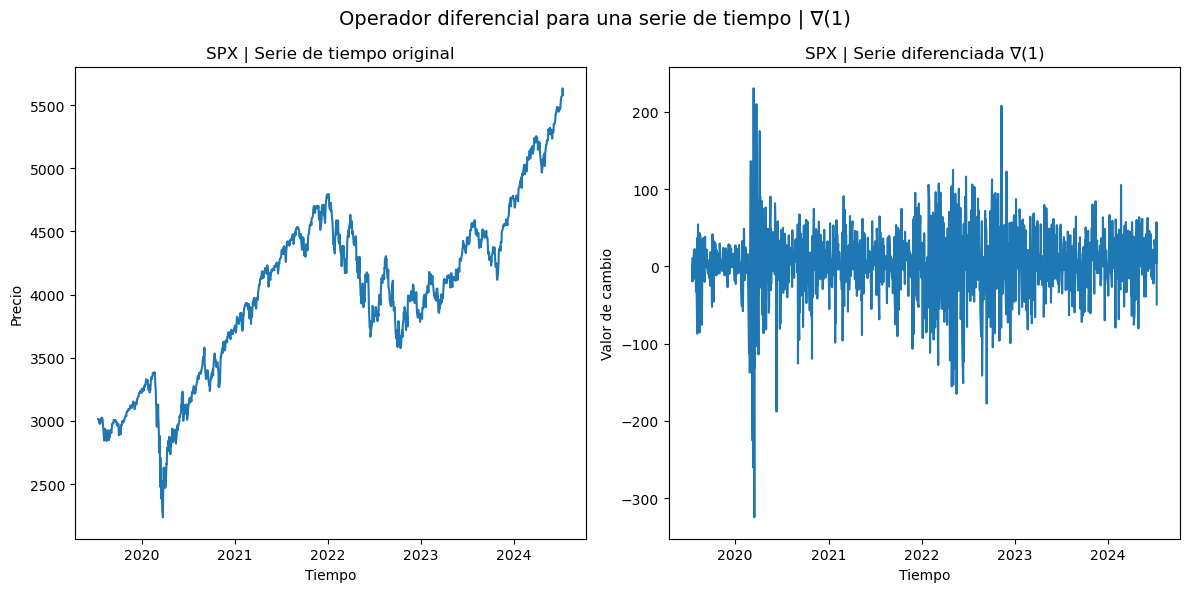

In [28]:
# Definimos n
n = 1
# Diferenciamos la serie
timeSeriesDiff = timeSeries.Price.diff(n)

# Ahora, ploteemos la serie diferenciada v.s. la serie original
# Creamos la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(
    f"Operador diferencial para una serie de tiempo | ∇({n})", 
    fontsize=14
)


# Primer subplot (serie original)
ax1.plot(timeSeries.Date, timeSeries.Price)
ax1.set_title("SPX | Serie de tiempo original")
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Precio')

# Segundo subplot (serie diferenciada con ∇(1))
ax2.plot(timeSeries.Date, timeSeriesDiff)
ax2.set_title("SPX | Serie diferenciada ∇(1)")
ax2.set_xlabel('Tiempo')
ax2.set_ylabel('Valor de cambio')

# Ploteamos
plt.tight_layout()
plt.show()

**Datito**: La serie de retornos financieros de una serie de tiempo es entendida como el "valor de cambio proporcional" o "ratio de cambio"; en otras palabras, es el crecimiento/decrecimiento sobre el desplazamiento ("raise/run"), por lo que también se le conoce coloquialmente como la derivada (discreta) de una serie de tiempo financiera. Esto es lo que puede observarse en el plot de $\nabla^1$. De ahí que, cuando se quiera trabajar para valores no enteros de $n$, se parta de la definición de _derivada fraccional_.

### 3.2. Series de Errores Residuales y Ruido Blanco

#### 3.2.1 Errores Residuales
La serie de errores residuales, conocida simplemente como _residuos_, es una serie temporal de las diferencias entre un valor observado y un valor predicho en un tiempo particular $t$.

> Si $y_t$ es el valor observado y $\hat{y}_t$ es el valor predicho, decimos que $e_t = y_t - \hat{y}_t$ son los residuos.

El punto clave en el análisis estándar de series de tiempo es que, si nuestro modelo de series temporales elegido es capaz de _"explicar" la correlación serial en las observaciones_, entonces **necesariamente los residuos NO estarán correlacionados serialmente**. Esto significará que cada elemento de la serie residual es una realización independiente de alguna distribución de probabilidad; es decir, los propios residuos son independientes e idénticamente distribuidos ($\text{i.i.d.}$).

#### 3.2.2 Ruido Blanco Discreto (_Discrete White Noise_, DWN)
Generado por un operador $\nabla$ sobre una serie, un DWN es cualquier serie temporal $\{W\}_{t=1:n}$ cuyos elementos son $\text{i.i.d.}$, con media constante, varianza $\sigma^2$ y sin correlación serial sobre $(t_1, t_n)$, es decir, $\text{Corr}(w_i, w_j) = 0, \space\forall i \neq j$.

> Si $w_t \sim N(0, \sigma^2)$, entonces $w_t$ es un **Ruido Blanco Gaussiano** (Gaussian White Noise).

Un ruido blanco gaussiano (estándar) tendrá $\sigma^2 = 1$.

**Propiedades de Segundo Orden del DWN**:
$$
E[w_t] = 0
$$

$$
\text{Var}(w_t) = \sigma^2
$$

$$
\text{Corr}(w_t, w_{t+k}) = 
\begin{cases} 
1 & \text{si } k = 0 \\
0 & \text{si } k \neq 0 
\end{cases}
$$

Recordar que denominamos "_propiedades de segundo orden_" a las características que involucran a la media, la varianza y, en consecuencia, a la correlación (revisar definición de _estacionariedad débil_ de la clase 2).

La forma clásica de generar un ruido blanco gaussiano en Python es directamente utilizando Numpy, y la funcionalidad `np.random.normal(...)`. 

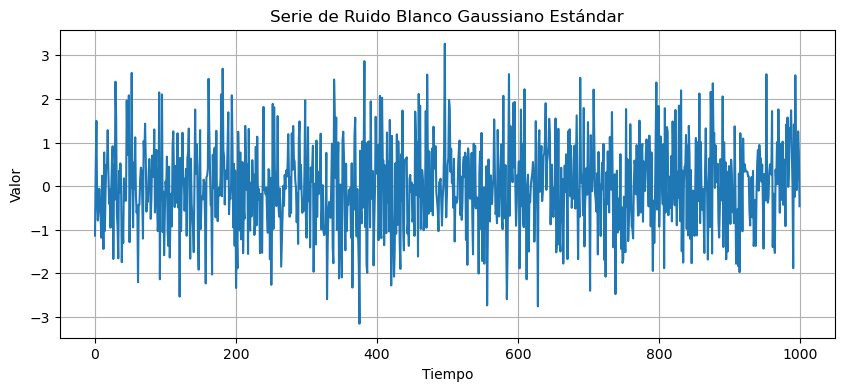

In [29]:
# Definimos un seed para reproductibilidad
np.random.seed(111)

# Definimos el total de puntos que deseamos
n = 1000
# Definimos el ruido blanco gaussiano estándar
white_noise = np.random.normal(0, 1, n)

# Ploteamos la serie de ruido blanco
plt.figure(figsize=(10, 4))
plt.plot(white_noise)
plt.title('Serie de Ruido Blanco Gaussiano Estándar')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

### 3.3. Paseo Aleatorio

#### 3.3.1 Definición
De la primera clase, sabemos que la Ecuación Diferencial Discreta (EDD) lineal básica que modela una serie de tiempo es conocida como "paseo aleatorio", o "random walk". Este es un modelo de serie temporal donde la observación actual es igual a la observación previa más un salto aleatorio. Cuando este "salto aleatorio" es un ruido blanco $w_t$, se le conocerá como "paseo aleatorio estándar" o "random walk estándar".

$$
x_t = x_{t-1} + w_t
$$

Donde si $w_t$ es ruido blanco gaussiano, $x_t$ será un **Gaussian Random Walk**.

#### 3.3.2 Propiedades del Paseo Aleatorio
- **Media:** La media de un paseo aleatorio es $0$.
- **Varianza:** La varianza crece con el tiempo, lo que significa que es un proceso _no estacionario_.
    
$$
\mu_x = 0
$$

$$
\gamma_k(t) = \text{Cov}(x_t, x_{t+k}) = t \sigma^2
$$
    
En otras palabras, $\sigma$ crece con la $\sqrt{t}$ (es decir, a medida que el tiempo aumenta, también lo hace la varianza). Por lo tanto, _no existe tendencia determinística_ en el proceso a lo largo del tiempo (son paseos aleatorios).

- **Correlograma**: Concretamente, para un RW estándar, estará definido como.

$$
\rho_k(t) = \frac{\text{Cov}(x_t, x_{t+k})}{\sqrt{\text{Var}(x_t) \text{Var}(x_{t+k})}} = \frac{t \sigma^2}{\sqrt{t\sigma^2 (t + k) \sigma^2}} = \frac{1}{\sqrt{1 + k/t}}
$$

#### 3.3.3. Paseo Aleatorio como suma de ruidos blancos 

Un paseo aleatorio puede definirse como _la suma sucesiva de una serie de ruidos blancos_ (**propiedad de dependencia aditiva**), pero **¿por qué?**

Primero, es importante entender la descomposición recursiva del RW:

1. **Primera Iteración:**
   $
   x_t = x_{t-1} + w_t
   $

2. **Segunda Iteración:**
   $
   x_t = (x_{t-2} + w_{t-1}) + w_t = x_{t-2} + w_{t-1} + w_t
   $

3. **Tercera Iteración:**
   $
   x_{t-2} = x_{t-3} + w_{t-2}
   $
   . Entonces,
   $
   x_t = ((x_{t-3} + w_{t-2}) + w_{t-1}) + w_t = x_{t-3} + w_{t-2} + w_{t-1} + w_t
   $

Y así sucesivamente.

Por lo tanto, podemos generalizar este proceso de forma recursiva $\forall k $-ésima iteración, tal que:

$$
x_t = x_{t-k} + \sum_{i=0}^{k-1} w_{t-i}
$$

Donde $ x_{t-k} $ es el valor inicial de la serie temporal y $ \sum_{i=0}^{k-1} w_{t-i} $ representa la suma de los términos de ruido blanco hasta el $ k $-ésimo término. Usualmente, $ x_{t-k} = 0$, permitiéndonos obtener la dependencia aditiva de ruidos blancos en un paseo aleatorio. 

Note que también podemos obtener la misma derivación para utilizando el BSO **B**, tal que, para las 3 primeras iteraciones:

1. **Iteraciones**
   - $
   x_t = x_{t-1} + w_t = B (x_t) + w_t
   $
   - $
   x_{t-1}  = x_{t-2} + w_{t-1} = B (x_{t-1}) + w_{t-1} = B^2 (x_{t}) + w_{t-1}
   $
   - $
   x_{t-2} = x_{t-3} + w_{t-2} = B (x_{t-2}) + w_{t-2} = B^3 (x_{t}) + w_{t-2}
   $
   
Y así sucesivamente.   

2. **Sustituyendo las iteraciones en $x_t$**:

$$
   x_t = B^3(x_t) + w_{t} + w_{t-1} + w_{t-2} = B^3(x_t) + w_t + B^1(w_t) + B^2(w_t)
$$


Tal que, generalizando $\forall k $-ésima iteración, podemos decir:


$$
   x_t = B^k (x_{t}) + \sum_{i=0}^{k-1} B^i (w_{t})
$$

donde normalmente $B^k (x_{t}) = 0$ (el inicio conocido del random walk).

En ese caso, $x_t$ puede expresarse completamente en función de $B$ como:

$$
x_t = \left(1 + B(\cdot) + B^2(\cdot) + ...\right)w_t
$$

Ahora bien, si bien es cierto que $x_t$ es una suma sucesiva de ruidos blancos, esto NO quiere decir que $x_t$ es estacionaria, ya que su varianza es el total de iteraciones $k$ por la varianza constante del ruido blanco $\sigma^2$; es decir, NO es finita.

Sin embargo, $x_t$ puede convertirse en un proceso estacionario mediante el operador de diferenciación $\nabla$.

#### 3.3.4. Diferenciación para obtener estacionariedad en un Paseo Aleatorio 

A nivel general, diferenciaremos $x_t$ para obtener una serie estacionaria:

$$
\nabla x_t = x_t - x_{t-1}
$$

donde, sustituyendo $x_t$ en términos de su definición, obtenemos:

$$
\nabla x_t = (x_{t-1} + w_t) - x_{t-1} = w_t
$$

Así, **la serie diferenciada $\nabla x_t$ es simplemente el ruido blanco $w_t$**, que, como ya vimos, posee propiedades que se cumplen con los criterios de estacionariedad. 

En Python, podemos generar un Random Walk Gaussiano Estándar fácilmente empleando la funcionalidad `np.cumsum`. Esto nos permitirá construir el paseo aleatorio sumando una serie sucesiva de ruidos blancos.

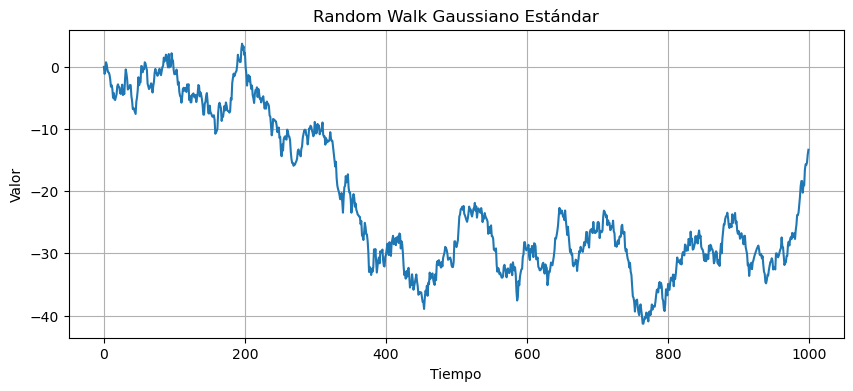

In [41]:
# Generar un paseo aleatorio
np.random.seed(111)
# Total de puntos deseados
n = 1000
# Definimos el vector con la suma acumulada de ruidos blancos
suma_acumulada_ruidos_blancos = np.cumsum(np.random.normal(0, 1, n-1))
# Definimos un valor inicial fijo para x0, normalmente x0 = 0
random_walk = np.insert(suma_acumulada_ruidos_blancos, 0, 0)

# Plotear el paseo aleatorio
plt.figure(figsize=(10, 4))
plt.plot(random_walk)
plt.title('Random Walk Gaussiano Estándar')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

***

## 4. Regresión lineal (una introducción)

### 4.1. Definición

La regresión lineal es una técnica estadística utilizada para modelar la relación entre una variable dependiente $ y $ y una o más variables independientes $ x $. Esta técnica asume una relación lineal entre las variables.

La ecuación de regresión lineal puede ser representada como:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_r x_r + \epsilon
$$

donde:
- $ \beta_0, \beta_1, \ldots, \beta_r $ son los coeficientes de regresión.
- $ \epsilon $ es el término de error aleatorio.
- $x = (x_1, \ldots, x_r)$, donde $r$ es el número de predictores.

### 4.2. Objetivo de la regresión

El objetivo de una regresión lineal (o incluso no lineal) es obtener una respuesta estimada o predicha, $\hat{y}_{i}$, para cada observación $x_i$, tal que esta sea lo más cercana posible al valor observado $y_i$. 

Las diferencias $e_i = y_i - \hat{y}_{i} \space \forall i=1:n$ es lo que anteriormente definimos como **residuos**. Así, la regresión trata de determinar los mejores pesos predichos, es decir, los pesos $\beta$ que permiten obtener los residuales más pequeños.

En términos técnicos, **el objetivo de la regresión es estimar los coeficientes $ \beta $ de manera que la _suma de los residuos cuadrados_ (RSS, en inglés) sea mínima**. Por tanto, puede decirse que **toda regresión es, por naturaleza, un proceso de optimización**.

### 4.3. Métodos de resolución del problema de regresión

#### 4.3.1 Suma de Residuales Cuadrados (_Residuals Sum of squared_ o RSS)

Así, para obtener los mejores pesos, usualmente se utilizará la _suma de residuales cuadrados_ (RSS) para todas las observaciones $i = 1:n$. Este RSS servirá como nuestra **función de optimización**, la cual está definida como:

$$
RSS = \sum_{i} (y_i - \hat{y}_i)^2
$$

El enfoque de usar la función RSS como función de optimización se llama el **Método de Mínimos Cuadrados Ordinarios (_ordinary least squares_ u OLS)**.

#### 4.3.2. Métodos de Mínimos Cuadrados - Least Squares | Enfoque general

El problema de mínimos cuadrados puede definirse como el estado en el que existen $N$ observaciones de pares ordenados $(x_i, y_i)$, y el objetivo es modelar la relación siguiendo:

$$
y_i = \beta x_i + \alpha + \epsilon_i
$$

donde los $\epsilon_i$ son errores y/o ruido pequeños.


Típicamente, los puntos observados no caerán convenientemente todos en una línea regresiva de forma exacta. Por tanto, el objetivo es encontrar los parámetros $\alpha$ y $\beta$ de modo que $\sum_{i=1}^N \epsilon_i^2$ sea lo más pequeño posible; es decir, que la **la suma de la distancia cuadrada de cada $x_i$ con respecto de la línea regresiva sea la menor posible**.

En el siguiente gráfico, buscamos reducir la suma de cada $\text{Error}$ al cuadrado:

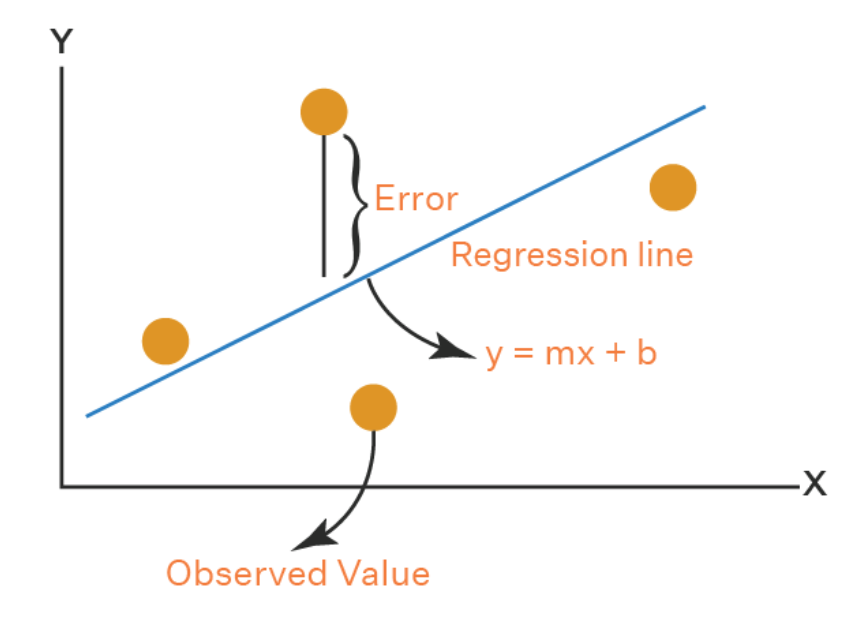

Existen dos formas clásicas para llevar a cabo el **Método de Mínimos Cuadrados**:

##### A. Álgebra lineal

Formulemos el conjunto de ecuaciones anterior como una ecuación matricial, estableciendo:

$$A = \begin{pmatrix} x_1 & 1 \\ x_2 & 1 \\ \vdots & \vdots \\ x_N & 1 \end{pmatrix}, \beta = \begin{pmatrix} \beta \\ \alpha \end{pmatrix}, y = \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_N \end{pmatrix}, \epsilon = \begin{pmatrix} \epsilon_1 \\ \epsilon_2 \\ \vdots \\ \epsilon_N \end{pmatrix}$$

de modo que tengamos

$$y = A\beta + \epsilon$$


En un modelo perfecto, podríamos encontrar $\beta$ de modo que $\|\epsilon\| = 0$ (donde $\|\cdot \|$ es la norma $L2$).

Sin embargo, sabemos que $y \in \mathbb{R}^N$. Además, el "column space" de $A$  es de dimensión 2, como máximo. Estas dos condiciones ocasionarán que, casi siempre, $\epsilon \neq 0$.

Pero, **¿por qué?**

> El "column space" (espacio columna) de la matriz $A$ es el _conjunto de todas las combinaciones lineales posibles de las columnas de $A$_. En este caso, la matriz $A$ tiene $2$ columnas, por lo que su "espacio columna" tiene dimensión 2, como máximo. Esto quiere decir que podemos formar cualquier combinación lineal de esas dos columnas, tal que encontremos la solución deseada. Sin embargo, el vector $y$ tiene $N$ componentes (el total de datos), y vive en un espacio de dimensión $N$ ($\mathbb{R}^N$). Esto significa que es muy poco probable que $y$ se encuentre exactamente dentro del espacio columna de $A$, ya que este espacio es solo un subespacio de dimensión $2$ dentro de un espacio mucho más grande (y, de hecho, infinitno). Como resultado, la probabilidad de encontrar un vector $\beta$ que haga que todos los errores $\epsilon = 0$ es básicamente nula, porque no podemos representar perfectamente todos los valores de $y$ usando solo combinaciones lineales de las dos columnas de $A$, como máximo. Así, la condición del "column space", y el espacio en el que vive $y$, LIMITAN las combinaciones posibles y, por lo tanto, siempre habrá algunos (o muchos) $\epsilon \neq 0$ dado que $y$ no se ajustará perfectamente al modelo.


##### B. Cálculo infinitesimal

Otra forma de resolución se encuentra en tratar de estimar $\beta$ para minimizar $\|y - A\beta\|_2^2$; es decir, **resolver un problema de minimización**.

Así, sea $E(\beta) = \|y - A\beta\|_2^2$, donde $E(\cdot)$ nuestra función de estimación. Entonces, para resolverlo, necesitamos establecer:

$$
\frac{dE(\beta)}{d\beta} = 0
$$

Dado que:

$$
E(\beta) = \|y - A\beta\|_2^2 = (y - A\beta)^T (y - A\beta)
$$

Podemos diferenciar, igual a $0$ y obtener el resultado final. 

Para ello, primero expandimos la expresión:

$$E(\beta) = (y - A\beta)^T (y - A\beta)$$

Esto se puede escribir como:

$$E(\beta) = y^T y - y^T A \beta - \beta^T A^T y + \beta^T A^T A \beta$$

Notamos que $y^T A \beta$ y $\beta^T A^T y$ son escalarmente iguales, es decir, $(y^T A \beta)^T = \beta^T A^T y$. Entonces, podemos simplificar esto a:

$$E(\beta) = y^T y - 2 y^T A \beta + \beta^T A^T A \beta$$

Ahora, derivamos esta expresión con respecto a $\beta$:

- La derivada de $y^T y$ con respecto a $\beta$ es $0$ porque $y^T y$ no depende de $\beta$.

- La derivada de $-2 y^T A \beta$ con respecto a $\beta$ es $-2 A^T y$.

- La derivada de $\beta^T A^T A \beta$ con respecto a $\beta$ es $2 A^T A \beta$.

>  Recordar la **regla de derivación para productos escalares con vectores**. La derivada de un producto escalar de la forma $c^T \beta$ (donde $c$ es un vector constante y $\beta$ es la variable) con respecto a $\beta$ es simplemente $c$. En este caso, $c = A^T y$.

> Recordar la **regla de derivación de una forma cuadrática vectorial**. Para una expresión de la forma $\beta^T C \beta$, donde $C$ es una matriz simétrica, la derivada con respecto a $\beta$ es $2C\beta$. En nuestro caso, $C = A^T A$ es simétrica (es decir, $C = C^T$, donde además $C$ es cuadrada).


Combinando estos resultados, obtenemos la derivada parcial de $E(\beta)$ respecto de $\beta$:

$$\frac{\partial E(\beta)}{\partial \beta} = -2 A^T y + 2 A^T A \beta=0$$

Simplificamos:

$$ A^T A \beta = A^T y $$

Finalmente, resolvemos para $\beta$:

$$ 
\beta = (A^T A)^{-1} A^T y 
$$

Esta es la forma de solución general para $\beta$.

**Datito**: la construcción $ (A^T A)^{-1} A^T $ se llama la "pseudoinversa" de $ A $.

#### 4.3.3.  Métodos de Mínimos Cuadrados - Least Squares | Propiedades y resolución estándar

Recuerde que comenzamos con $N$ observaciones de pares ordenados $(x_i, y_i)$ y el objetivo es modelar la relación como

$$
y_i = \beta x_i + \alpha + \epsilon_i
$$

Asumimos que $x_i$ son valores observados de una variable aleatoria $X$. Por lo tanto, podemos resumir nuestro modelo como

$$
Y = \beta X + \alpha + \epsilon \space\space\space\space\space (\star)
$$

donde modelamos $\epsilon \sim N(0, \sigma^2) \land \epsilon \perp X$.

A partir de esto, podemos encontrar algunas **propiedades interesantes**.

Primero, tomamos $\mathbb{E}[\cdot]$ de ambos lados de $(\star)$ para obtener:

$$
\mathbb{E}[Y] = \beta \mathbb{E}[X] + \alpha + \mathbb{E}[\epsilon] = \beta \mathbb{E}[X] + \alpha
$$

Así,

$$
\alpha = \mathbb{E}[Y] - \beta \mathbb{E}[X]
$$

Luego, observamos la covarianza:

$$
\begin{align}
Cov(X,Y) = & Cov(X, \alpha + \beta X + \epsilon) \\
= & Cov(X, \alpha) + \beta Cov(X, X) + Cov(X, \epsilon) \\
= & 0 + \beta Cov(X, X) + 0 = \beta Var(X)
\end{align}
$$

Por lo tanto, $\beta \land \alpha$ pueden definirse como:

$$\beta = \frac{Cov(X, Y)}{Var(X)} \space\space \land \space\space \alpha = \mathbb{E}[Y] - \beta \mathbb{E}[X]$$

Apartir de esto, podemos podemos construir soluciones esperadas para ambos valores utilizando los conceptos que vimos en la clase 2 sobre teoría de probabilidad.

Así, definimos algunos valores esenciales:

- $\bar{x} = \frac{x_1 + x_2 + \ldots + x_n}{n},$

- $\bar{y} = \frac{y_1 + y_2 + \ldots + y_n}{n},$

- $s_{xx} = \sum_{i=1}^n (x_i - \bar{x})^2,$

- $s_{xy} = \sum_{i=1}^n (x_i - \bar{x}) (y_i - \bar{y}).$

Donde 

- $s_{xx}$: es la suma de los cuadrados de las diferencias de cada valor de $x$ respecto a la media de $x$. **Es el numerador de la varianza muestral**.
- $s_{xy}$: es la suma de los productos de las diferencias de cada valor de $x$ y $y$ respecto a sus respectivas medias. **Es el numerador de la covarianza muestral**.

Dado que tanto varianza como covarianza muestral comparten el coeficiente $\frac{1}{n-1}$, entonces:

$$\hat{\beta} = \frac{s_{xy}}{s_{xx}}  \space\space\space\land\space\space\space \hat{\alpha} = \bar{y} - \hat{\beta} \bar{x}$$

Estas fórmulas nos permitirán obtener la tan ansiada **línea de regresión**:

> $$
\hat{y} = \hat{\alpha}+ \hat{\beta} x
$$

tal que $e = \hat{y} - y$ es nuestro residuo.

A nivel aplicativo, esto se aplicará sobre cada $i$, tal que tengamos $\hat{y} = \{\hat{y}_{i=1:n}\}$.

Esta línea de regresión es la famosamente conocida como $\text{OLS regression}$ para regresiones lineales, y $\text{LS regression}$ para regresiones en general.

> **Importante**: Least Squares (Mínimos Cuadrados)es el método general que minimiza la suma de los cuadrados de los residuos para todo problema regresivo. Ordinary Least Squares (Mínimos Cuadrados Ordinarios) es UN método específico de regresión lineal, dentro del enfoque LS, que minimiza la suma de los cuadrados de los residuos _bajo ciertos supuestos_, tales como errores independientes, normalmente distribuidos, y homocedásticos. Dado que nosotros hemos trabajado sobre estos supuestos, lo llamamos $\text{OLS regression}$.

Sin embargo, a pesar de que tenemos nuestra línea de regresión con $\hat{y}$, requerimos de una métrica sólida que podamos evaluar. Esta es conocida como el **Coeficiente de Determinación R-Cuadrado**.

##### 4.3.4.  Métodos de Mínimos Cuadrados - Least Squares | R-Cuadrado o $R^2$

Empecemos por evaluar nuevamente nuestro modelo:

$$
Y = \beta X + \alpha + \epsilon
$$

Ahora bien, si miramos la varianza de $Y$, podemos escribir:

$$
Var(Y) = \beta^2 Var(X) + Var(\epsilon)
$$

Entonces la variación total en $Y$ se puede dividir en dos partes.

- La primera parte, $\beta^2 Var(X)$, se debe a la variación en $X$.
- La segunda parte, $Var(\epsilon)$, es la varianza del error.

Definimos entonces:

$$
\rho^2 = \frac{\beta^2 Var(X)}{Var(Y)}
$$

como la **porción de la varianza de $Y$ que es explicada por la variación en $X$** (esto no es el coeficiente de correlación... al menos no todavía).

Entonces, es evidente que:

$$0 \leq \rho^2 \leq 1$$

Ahora bien, dado que $\beta = \frac{Cov(X, Y)}{Var(X)}$, podemos definir:

$$
\rho^2 = \frac{Cov(X, Y)^2}{Var(X) Var(Y)} \space\space\space\space (\star\star)
$$

Nota que $\rho$, ahora sí, es el **coeficiente de correlación**. De la sesión 2, podemos recordar que el coeficiente de correlación se obtiene normalizando/estandarizando la covarianza. En particular, definimos el coeficiente de correlación de dos variables aleatorias $X$ e $Y$ como la covarianza de las versiones estandarizadas de $X$ e $Y$.

Definimos las versiones estandarizadas de $X$ e $Y$ como

$$
U = \frac{X - \mathbb{E}[X]}{\sigma_X}
\space\space\space \land \space\space\space
V = \frac{Y - \mathbb{E}[Y]}{\sigma_Y}
$$

Entonces, la $\rho_{X,Y}$ de nuestra regresión quedará definida como:

$$
\rho_{XY} = Cov(U, V) = Cov\left(\frac{X - \mathbb{E}[X]}{\sigma_X}, \frac{Y - \mathbb{E}[Y]}{\sigma_Y}\right) = \frac{Cov(X, Y)}{\sigma_X \sigma_Y}
$$

Así, **definiremos el coeficiente de determinación, $R^2$,** tomando $(\star\star)$, tal que:

> $$
R^2 = \frac{Cov(X, Y)^2}{Var(X) Var(Y)} = \frac{s_{xy}^2}{s_{xx} s_{yy}}
$$

donde

- $s_{xx} = \sum_{i=1}^n (x_i - \bar{x})^2$
- $s_{yy} = \sum_{i=1}^n (y_i - \bar{y})^2 $ (también llamado $\text{TSS}$, o $\text{Total Sum of Squares}$)
- $s_{xy} = \sum_{i=1}^n (x_i - \bar{x}) (y_i - \bar{y})$

Note que:
- $\text{TSS}$: _Total Sum of Squares_, o la suma de los cuadrados de las diferencias. Mide la cantidad total de variabilidad presente en los datos. Es una medida de la dispersión de los valores observados alrededor de su media.

> De ahí que, conceptualmente, **el $R^2$ evalúe la _proporción_ de la variación de $Y$ que es EXPLICADA por la variación en $X$**.

> **Importante**: Una forma más "holística" de ver el $R^2$ es utilizando directamente los residuos, es decir:
>
> $$ R^2 = 1 - \frac{\text{RSS}}{\text{TSS}} = 1 - \frac{\sum e_i^2}{\sum (y_i - \bar{y})^2} $$

donde, ya vimos (seción 4.1.), que $ \text{RSS} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2  = \sum_{i=1}^{n} e_i^2 $.

1. **RSS (Residual Sum of Squares)**:
   $$ RSS = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

2. **TSS (Total Sum of Squares)**:
   $$ TSS = \sum_{i=1}^{n} (y_i - \bar{y})^2 $$

3. **\( R^2 \) (Coeficiente de determinación)**:
   $$ R^2 = 1 - \frac{RSS}{TSS} $$

**Apéndice: $R^2$ Ajustado**

Vayamos a Wikipedia:
> El uso de un $R$ ajustado es un intento de tener en cuenta el fenómeno de que $R^2$ aumenta automáticamente y espuriamente cuando se añaden variables explicativas adicionales al modelo. Hay muchas formas diferentes de ajustar. La más utilizada, hasta el punto de que típicamente se le llama simplemente $R$ ajustado, es la corrección propuesta por Mordecai Ezekiel. 

El $R$ ajustado (según Ezekiel) se define como:

$$\bar{R}^2 = 1 - \left(1 - R^2\right) \frac{n - 1}{n - p - 1}$$

donde $p$ es el número total de variables explicativas en el modelo (sin incluir el término constante), y $n$ es el tamaño de la muestra.

### 4.4. Implementación de regresión lineal (en Python)

Directamente, supongamos que tenemos el siguiente conjunto de datos:

In [42]:
# Datos
x = [[0, 1], [5, 1], [15, 2], [25, 5], [35, 11], [45, 15], [55, 34], [60, 35]]
y = [4, 5, 20, 14, 32, 22, 38, 43]
x, y = np.array(x), np.array(y)
# Imprimamos X e Y
print(f">> V. Independientes (X): \n{x}")
print(f">> V. Dependientes (Y): {y}")

>> V. Independientes (X): 
[[ 0  1]
 [ 5  1]
 [15  2]
 [25  5]
 [35 11]
 [45 15]
 [55 34]
 [60 35]]
>> V. Dependientes (Y): [ 4  5 20 14 32 22 38 43]


Note que tenemos $2$ features (es decir, 2 predictores), ya que $\text{col}(X)= 2$. Ahora bien, solo como referencia, ploteemos $X\land Y$:

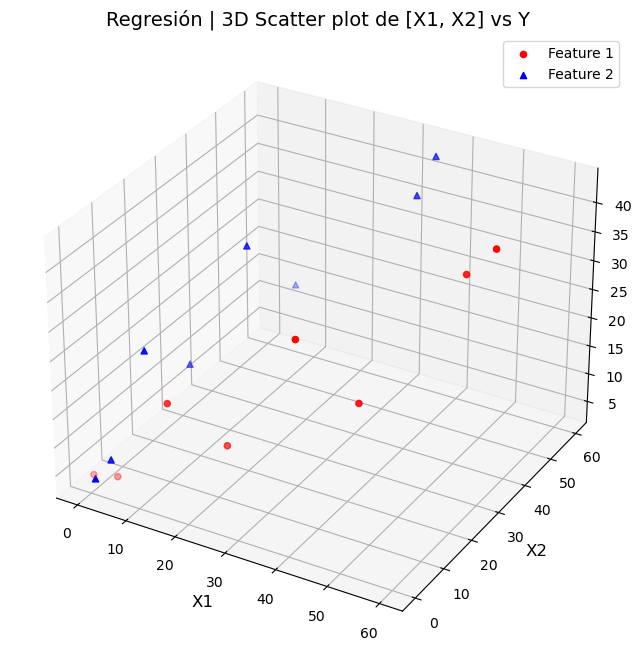

In [43]:
# Crear la figura y el eje 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos 3D con diferentes colores
ax.scatter(x[:, 0], x[:, 1], y, c='r', marker='o', label='Feature 1')
ax.scatter(x[:, 1], x[:, 0], y, c='b', marker='^', label='Feature 2')

# Etiquetas y título
ax.set_zlabel('Y', fontsize=12)
ax.set_xlabel('X1', fontsize=12)
ax.set_ylabel('X2', fontsize=12)
ax.set_title('Regresión | 3D Scatter plot de [X1, X2] vs Y', fontsize=14)

# Añadir la leyenda
ax.legend()

# Mostrar el plot
plt.show()

Ahora bien, como vimos en la definición matricial (sección _4.3.2._, parte _A_), es necesario añadir el vector $\mathbf{1}$ como columna a las entradas de $X$ para que el modelo calcule un intercepto $b_0$.

In [44]:
# Agregando vector 1 a x
x = sm.add_constant(x)

# Imprimamos
print(f">> Intercepto inicial (b) + V. Independientes (X) : \n{x}")
print(f">> V. Dependientes (Y): {y}")

>> Intercepto inicial (b) + V. Independientes (X) : 
[[ 1.  0.  1.]
 [ 1.  5.  1.]
 [ 1. 15.  2.]
 [ 1. 25.  5.]
 [ 1. 35. 11.]
 [ 1. 45. 15.]
 [ 1. 55. 34.]
 [ 1. 60. 35.]]
>> V. Dependientes (Y): [ 4  5 20 14 32 22 38 43]


Finalmente, basta llamar a la funcionalidad `OLS` de `sm` (statsmodel) para poder obtener los resultados de nuestra regresión lineal:

In [45]:
# Creamos un modelo y fiteamos (ajustamos) nuestros datos
model = sm.OLS(y, x)
results = model.fit()

# Finalmente, imrprimimos los resultados
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     15.56
Date:                Sun, 02 Jun 2024   Prob (F-statistic):            0.00713
Time:                        13:24:57   Log-Likelihood:                -24.316
No. Observations:                   8   AIC:                             54.63
Df Residuals:                       5   BIC:                             54.87
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5226      4.431      1.246      0.2

Hay MUCHOS datos aquí que discutiremos laa siguientea sesionwa (sesión 4 y 5), pero podemos mencionar algunos resultados interesantes:

1. **$ R^2 $ (Coeficiente de determinación)**:
   - **Valor**: 0.862
   - **Significado**: El 86.2% de la variabilidad en $ Y $ se puede explicar por las variables $ X1 $ y $ X2 $. Esto indica que el modelo ajusta bastante bien los datos.


2. **Coeficiente para $X1$**:
   - **Valor**: 0.4471
   - **Significado**: Por cada unidad que aumenta $ X1 $, $ Y $ aumenta en 0.4471 unidades, manteniendo $ X2 $ constante. Aunque no es muy grande, es positivo, lo que sugiere una relación directa entre $ X1 $ y $ Y $.


3. **Coeficiente para $X2$**:
   - **Valor**: 0.2550
   - **Significado**: Por cada unidad que aumenta $ X2 $, $ Y $ aumenta en 0.2550 unidades, manteniendo $ X1 $ constante. Este coeficiente es menor que el de $ X1 $, indicando que $ X2 $ tiene un efecto positivo pero más pequeño en $ Y $.


4. **$ P $-valor de los coeficientes** (veremos como calculamos esto en la sesión 4):
   - **Para $X1$**: 0.178
     - **Interpretación**: Este valor es mayor que 0.05, lo que sugiere que el coeficiente de $ X1 $ no es estadísticamente significativo al nivel del 5%. Esto significa que no hay suficiente evidencia para afirmar que $ X1 $ tiene un efecto diferente de cero (significativo) sobre $ Y $.
   - **Para $X2$**: 0.598
     - **Interpretación**: Este valor también es mayor que 0.05, indicando que el coeficiente de $ X2 $ no es estadísticamente significativo al nivel del 5%. Similarmente, no hay suficiente evidencia para afirmar que $ X2 $ tiene un efecto diferente de cero sobre $ Y $.


5. **Constante (intercepto)**, o $\alpha$:
   - **Valor**: 5.5226
   - **Significado**: Cuando $ X1 $ y $ X2 $ son cero, el valor esperado de $ Y $ es aproximadamente 5.5226. Esto es el punto donde la línea de regresión corta el eje $ Y $.


En resumen:
- **$ R^2 $** alto sugiere un buen ajuste del modelo.
- **Coeficientes** positivos para $ X1 $ y $ X2 $, pero sus $ P $-valores indican que no son estadísticamente significativos en este caso.

**Datito**: Recuerde que un modelo autoregresivo AR no es sino la combinación del concepto de paseo aleatorio (o dependencia serial) con el de una regresión. A nivel discreto, todo modelo AR es un modelo discreto lineal de crecimiento exponencial y constante (vea sesión 1). Más sobre modelos AR en la sesión 4.   

### 4.5. Implementación de regresión lineal (ejemplo a mano paso a paso)

Digamos que tenemos los puntos de datos:
$$\{(x_i, y_i): (-5, -2), (-3, 1), (0, 4), (2, 6), (1, 3)\}$$

1. **Calcular la línea de regresión estimada basada en los datos observados**:

Observe que:
$$\bar{x} = \frac{-5 - 3 + 0 + 2 + 1}{5} = \frac{-5}{5} = -1$$
$$\bar{y} = \frac{-2 + 1 + 4 + 6 + 3}{5} = \frac{12}{5} = 2.4$$

Entonces, dado que:

$$
\hat{\beta} = \frac{s_{xy}}{s_{xx}}  = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2} \space\space \land \space\space \hat{\alpha} = \bar{y} - \hat{\beta}\bar{x}
$$

Podemos decir:

$$\hat{\beta} = \frac{(-5 - (-1))(-2 - 2.4) + (-3 - (-1))(1 - 2.4) + (0 - (-1))(4 - 2.4) + (2 - (-1))(6 - 2.4) + (1 - (-1))(3 - 2.4)}{(-5 - (-1))^2 + (-3 - (-1))^2 + (0 - (-1))^2 + (2 - (-1))^2 + (1 - (-1))^2} = \frac{34}{34} = 1$$

$$\hat{\alpha} = 2.4 - 1(-1) = 3.4$$

Por lo tanto:

$$\hat{y} = \hat{\alpha} + \hat{\beta}x = 3.4 + x$$


2. **Encontrar el valor ajustado de $y_i$**:

Dada la línea de regresión:
$$\hat{y} = 3.4 + x$$

Los valores ajustados para cada $x_i$ se calculan como $\hat{y}_i = \hat{\alpha} + \hat{\beta}x_i$:

$$
\hat{y}_{i, x=-5} = 3.4 + 1(-5) = -1.6 \\
\hat{y}_{i, x=-3} = 3.4 + 1(-3) = 0.4 \\
\hat{y}_{i, x=0} = 3.4 + 1(0) = 3.4 \\
\hat{y}_{i, x=2} = 3.4 + 1(2) = 5.4 \\
\hat{y}_{i, x=1} = 3.4 + 1(1) = 4.4
$$


3. **Calcular los residuos $e_i=y_i−\hat{y}_i$:**

Dados los valores ajustados $\hat{y}_i$, los residuos se calculan como $e_i = y_i - \hat{y}_i$:

$$
e_{i, x=-5} = -2 - (-1.6) = -0.4000 \\
e_{i, x=-3} = 1 - 0.4 = 0.6000 \\
e_{i, x=0} = 4 - 3.4 = 0.6000 \\
e_{i, x=2} = 6 - 5.4 = 0.6000 \\
e_{i, x=1} = 3 - 4.4 = -1.4000
$$

4. **Calcular el R-cuadrado:**

Dados los residuos $e_i$ y la media de $y$, $\bar{y} = 2.4$, el valor de R-cuadrado se calcula como:

$$ R^2 = 1 - \frac{RSS}{TSS} = 1 - \frac{\sum e_i^2}{\sum (y_i - \bar{y})^2} $$

Después de realizar los cálculos:

$$
R^2 = 1 - \frac{\sum e_i^2}{\sum (y_i - \bar{y})^2} \approx 0.9140
$$

5. **Confirmar los resultados en Python:**

Finalmente, siempre es conveniente confirmar nuestra solución con el software de nuestra preferencia.

In [46]:
# Colocamos la data
x = np.array([-5, -3, 0, 2, 1])
y = np.array([-2, 1, 4, 6, 3])

# Agregamos intercepto
x_with_const = sm.add_constant(x)

# Fiteamos el modelo
model = sm.OLS(y, x_with_const)
results = model.fit()

# Imprimimos resultados
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     31.88
Date:                Sun, 02 Jun 2024   Prob (F-statistic):             0.0110
Time:                        13:31:43   Log-Likelihood:                -5.9790
No. Observations:                   5   AIC:                             15.96
Df Residuals:                       3   BIC:                             15.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4000      0.495      6.873      0.0

### Reto #4 (en Python) | 1.5 pt - 5 minutos

Digamos que tenemos los siguientes datos:

$$
\{(x_i, y_i): (2, 5), (7, 15), (-1, -2), (3, 9), (1, 4)\}
$$

Imaginemos que no existe la librería `statsmodel`. 

Entonces, **realice una función en Python que implemente la regresión lineal** sobre el conjunto de datos. El `output` de la función debe ser una `tupla` o `lista`, tal que se retorne: 
- $\hat{\beta}$
- $\hat{\alpha}$
- $R^2$ 

**Solución**:

In [47]:
# Solucion al Reto N4 - Curso Series de Tiempo
# Dessarrollado por Frank Ygnacio

def regresionLineal(x, y):
    """
    La presente funcion toma dos arrays, x e y, de la 
    msima dimension. Devuelve la tupla deseada.
    """
    
    # Calcular las medias de x y y
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    # Calcular beta
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sum((x - x_mean) ** 2)
    beta = numerator / denominator
    
    # Calcular alpha
    alpha = y_mean - beta * x_mean
    
    # Calcular los valores ajustados de y
    y_hat = alpha + beta * x
    
    # Calcular los residuos
    residuals = y - y_hat
    
    # Calcular R^2
    ss_total = np.sum((y - y_mean) ** 2)
    ss_residual = np.sum(residuals ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    
    return beta, alpha, r_squared

# Datos proporcionados
x = np.array([2, 7, -1, 3, 1])
y = np.array([5, 15, -2, 9, 4])

# Llamada a la función
beta, alpha, r_squared = regresionLineal(x, y)

print(f">> Beta: {beta}")
print(f">> Alpha: {alpha}")
print(f">> R^2: {r_squared}")

# Resultados comprobables mediante:

# Agregamos intercepto
x_with_const = sm.add_constant(x)

# Fiteamos el modelo
model = sm.OLS(y, x_with_const)
results = model.fit()

# Ver los resultados 
print(results.summary())

>> Beta: 2.090909090909091
>> Alpha: 1.1818181818181825
>> R^2: 0.9690863292878406
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     94.04
Date:                Sun, 02 Jun 2024   Prob (F-statistic):            0.00233
Time:                        13:52:13   Log-Likelihood:                -7.0488
No. Observations:                   5   AIC:                             18.10
Df Residuals:                       3   BIC:                             17.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------